In [1]:
%matplotlib inline

In [2]:
# Copyright IonQ Inc., all rights reserved

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import pandas as pd
import seaborn as sns
import warnings
import os
import json

In [3]:
plt.rcParams['text.usetex'] = True

## 2Q DRB plots

In [4]:
dataDRB = pd.read_json('../results/data_DRB2Q.json')

In [5]:
(dataDRB['err_2q_ci'] / dataDRB['err_2q']).describe()

count    5080.000000
mean        0.341479
std         0.538800
min         0.039027
25%         0.218351
50%         0.298410
75%         0.399836
max        34.826953
dtype: float64

In [6]:
dataDRBByPair = dataDRB.groupby('qubit pair')[['err_1q', 'err_1q_ci', 'err_2q', 'err_2q_ci', 'infidelity_pptt', 'qubit distance', 'q0', 'q1']].mean().copy()
dataDRBByPair[['q0', 'q1', 'infidelity_pptt']].to_json("fig_2QDRB_by_pair.json")

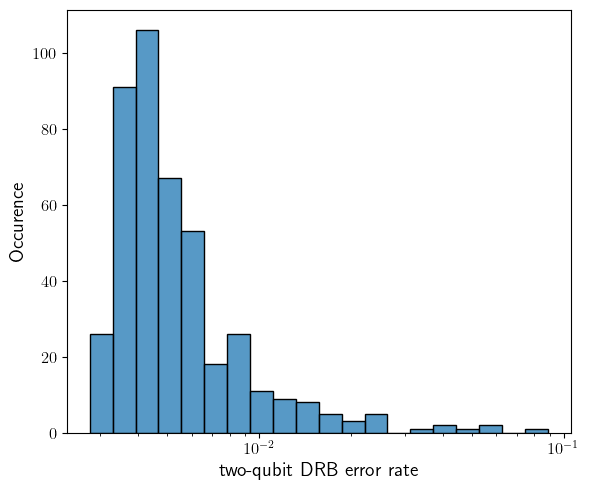

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.histplot(data=dataDRBByPair, x=dataDRBByPair['infidelity_pptt'] * 1e-4, stat='count', log_scale=True, bins=20, ax=ax)
ax.set_ylabel('Occurence', fontsize=14);
ax.set_xlabel(r'two-qubit DRB error rate', fontsize=14);  # \textpertenthousand

ax.tick_params(axis='both', labelsize=12)
fig = plt.gcf()
fig.set_size_inches(6,5)
fig.tight_layout()

plt.savefig('DRB_2Q_hist.pdf')

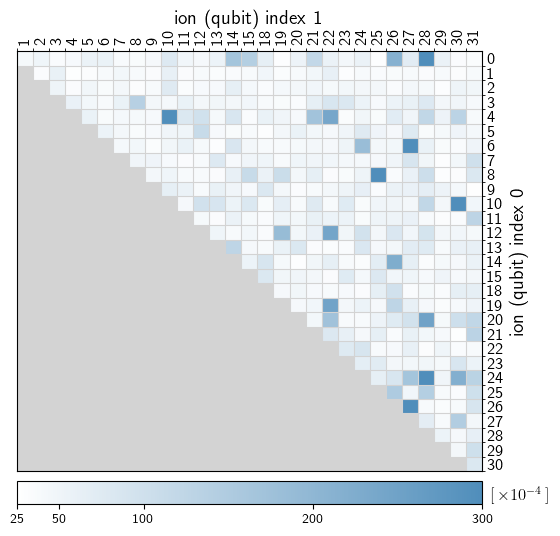

In [8]:
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LinearSegmentedColormap

df_by_index = dataDRBByPair.pivot(columns='q1', index='q0', values='infidelity_pptt')
a = df_by_index.to_numpy() * 1e-4  # convert pptt => decimal
# a is data to plot: a.shape == (29, 29)

vmin = 25 * 1e-4
vmax = 300 * 1e-4
m = (46.4-vmin) / (vmax-vmin)
cdict = {'red':   [[0.0,  1, 1],
                   [1.0,  80/255, 80/255]],
         'green': [[0.0,  1, 1],
                   [1.0,  142/255, 142/255]],
         'blue':  [[0.0,  1, 1],
                   [1.0,  187/255, 187/255]]}
newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_facecolor("lightgray")
plt.pcolormesh(np.flipud(a), vmin=vmin, vmax=vmax, cmap=newcmp) #"Blues")
cbar = plt.colorbar(ticks=np.array([25, 50, 100, 200, 300])*1e-4,
                    orientation="horizontal",fraction=0.07,anchor=(0.0,1.0), pad=0.02)
cbar.ax.set_xticklabels([25, 50, 100, 200, 300])
#cbar.ax.set_ylabel('$[\mathrm{pptt}]$', fontsize=12, rotation=0) #, rotation=270)
#cbar.ax.yaxis.set_label_position("right")
fig.text(0.915, 0.14, '$[\\,\\times 10^{-4}\,]$', fontsize=12, ha='left', va='center', rotation=0)
plt.yticks(ticks=np.arange(len(df_by_index.index))+0.5, labels=reversed(list(map(int,df_by_index.index))), rotation=0, fontsize=12);
plt.xticks(ticks=np.arange(len(df_by_index.columns))+0.5, labels=list(map(int,df_by_index.columns)), rotation=90, fontsize=12);
#plt.text(0.04, 0.04, "2-qubit DRB error rate", transform=ax.transAxes, fontsize=15)
plt.xlabel('ion (qubit) index 1', fontsize=14)
plt.ylabel('ion (qubit) index 0', fontsize=14)
ax.xaxis.set_minor_locator(FixedLocator(np.arange(len(df_by_index.columns))))
ax.yaxis.set_minor_locator(FixedLocator(np.arange(len(df_by_index.index))))
ax.xaxis.tick_top()
ax.yaxis.tick_right()
ax.xaxis.set_label_position("top")
ax.yaxis.set_label_position("right")
ax.tick_params('both', length=0, width=2, which='major')
plt.grid(which='minor', color="lightgray")
plt.savefig("fig_2qdrb_by_qubits.pdf", format="pdf", bbox_inches = 'tight')

### 2Q decay curve

In [9]:
df_2QDRB_decay_data = pd.read_json("../results/data_DRB2Q_decaydata.json")

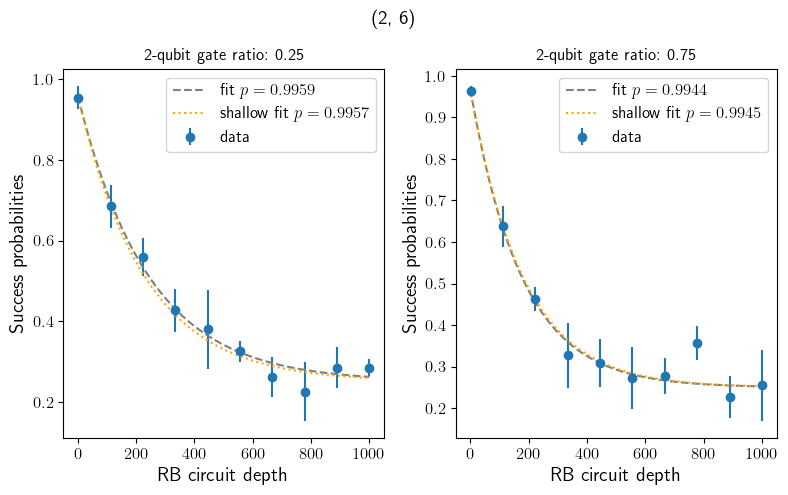

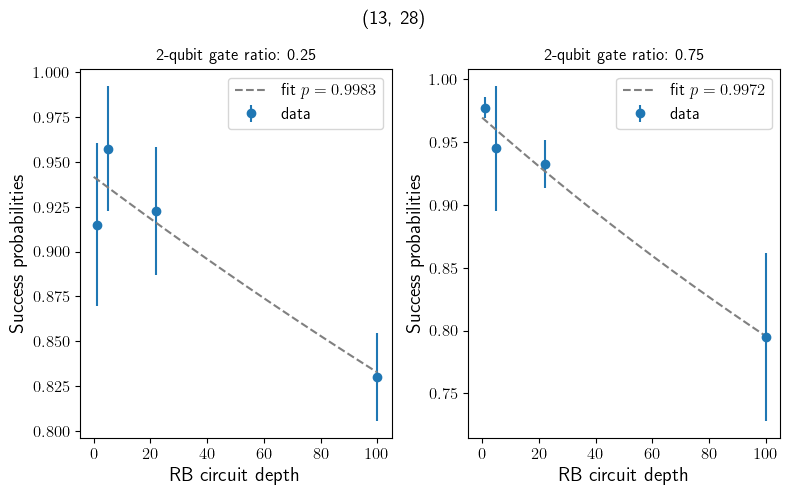

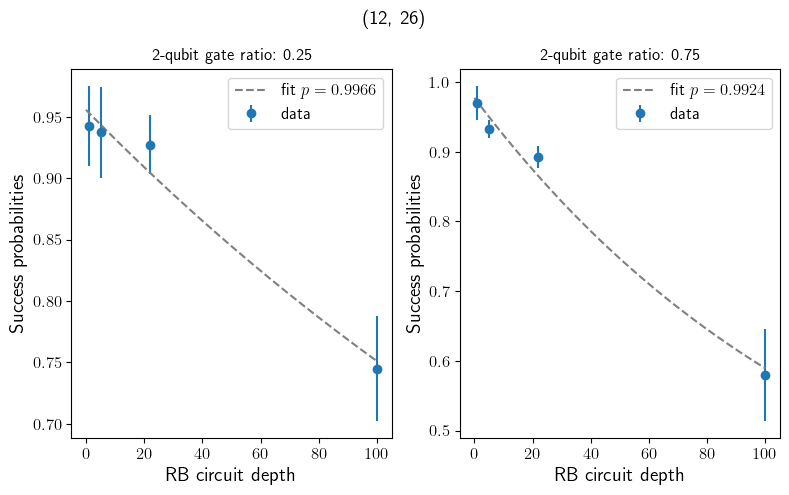

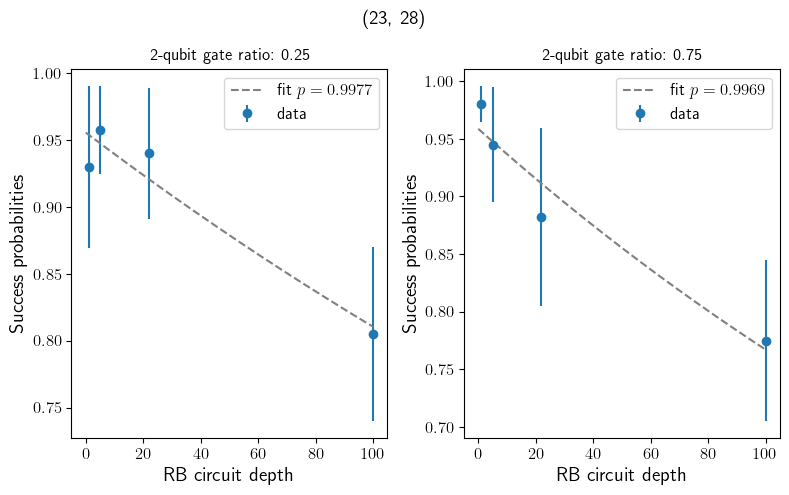

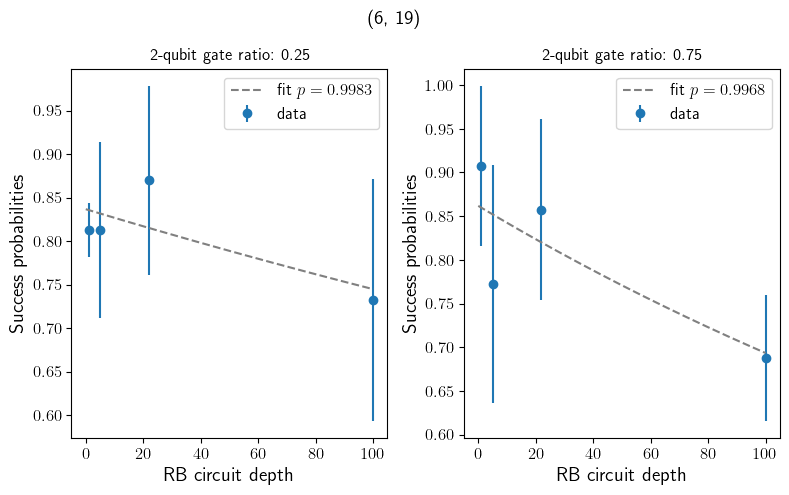

In [10]:
def plotRB2Qdata(df, qubit_pair, outfile=None):
    df = df[df['qubit_pair'] == qubit_pair]
    df_notrunc = df[df['truncated'] == False]
    fig, axs = plt.subplots(nrows=1, ncols=len(df_notrunc), figsize=(4*len(df_notrunc), 5))
    for ax, (_, row) in zip(axs, df_notrunc.iterrows()):
        twoQ_gate_ratio = row['two_qubit_gate_ratio']
        a, b, p = row['fit_a'], row['fit_b'], row['fit_p']
        depths = row['depths']
        success_probs_by_depth = row['success_probs_by_depth']
        avg_success_probs = [np.mean(sprobs) for sprobs in success_probs_by_depth]
        std_success_probs = [np.std(sprobs) for sprobs in success_probs_by_depth]

        #ax.plot(depths, avg_success_probs, 'o', label='mean')
        ax.errorbar(depths, avg_success_probs, yerr=std_success_probs, fmt='o', label='data')

        lengths = np.linspace(0, max(depths), 200)
        ax.plot(lengths, a + b * p**lengths, label=f'fit $p={p:.4f}$',
                color='gray', ls='--')
        
        df_truncated = df[(df['truncated'] == True) & (df['two_qubit_gate_ratio'] == twoQ_gate_ratio)]
        if len(df_truncated) > 0:
            trunc_row = df_truncated.iloc[0]
            at, bt, pt = trunc_row['fit_a'], trunc_row['fit_b'], trunc_row['fit_p']
            ax.plot(lengths, at + bt * pt**lengths, label=f'shallow fit $p={pt:.4f}$',
                    color='orange', ls=':')
        
        ax.legend(fontsize=12)
        ax.tick_params(axis='both', labelsize=12)
        
        ax.set_title(f'2-qubit gate ratio: {twoQ_gate_ratio}')
        ax.set_xlabel('RB circuit depth', fontsize=14)
        ax.set_ylabel('Success probabilities', fontsize=14)
        
    fig.suptitle(str(qubit_pair), fontsize=14)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, format="pdf", bbox_inches = 'tight')

df_2QDRB_decay_data['qubit_pair'] = df_2QDRB_decay_data.apply(lambda x: tuple(x['qubit_pair']), axis=1)
qubit_pairs = df_2QDRB_decay_data['qubit_pair'].unique()
for qubit_pair in qubit_pairs:
    plotRB2Qdata(df_2QDRB_decay_data, qubit_pair, f"fig_2qdrb_decay_{qubit_pair[0]}_{qubit_pair[1]}.pdf")

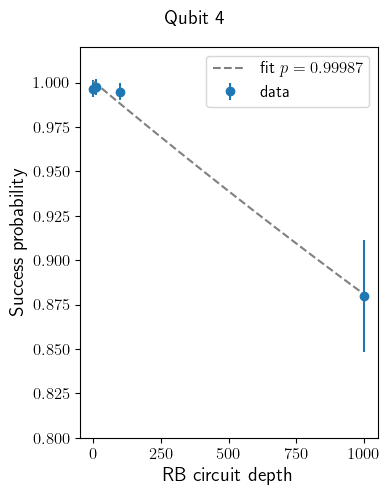

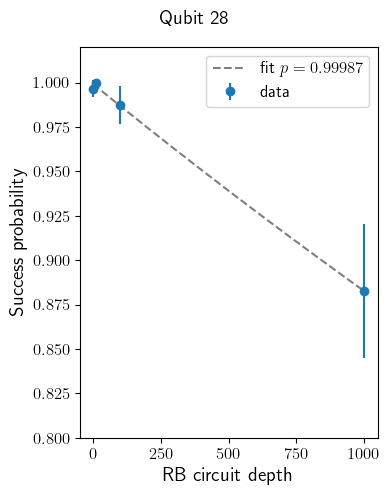

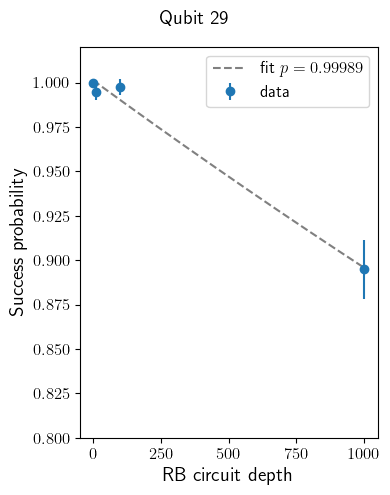

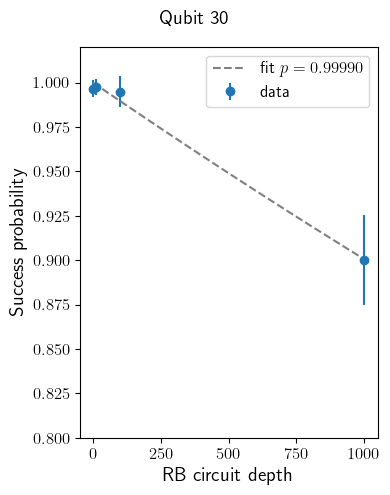

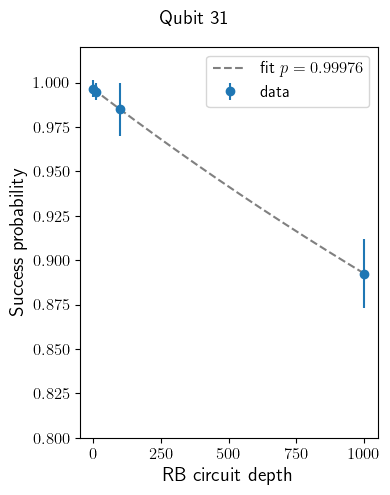

In [12]:
def plotRB1Qdata(df, qubit, outfile=None):
    df = df[df['qubit'] == qubit]
    row = df.iloc[0]  # just plot first entry for this qubit

    fig, ax = plt.subplots(figsize=(4,5))
    
    a, b, p = row['fit_a'], row['fit_b'], row['fit_p']
    depths = row['depths']
    success_probs_by_depth = row['success_probs_by_depth']
    avg_success_probs = [np.mean(sprobs) for sprobs in success_probs_by_depth]
    std_success_probs = [np.std(sprobs) for sprobs in success_probs_by_depth]

    ax.errorbar(depths, avg_success_probs, yerr=std_success_probs, fmt='o', label='data')

    lengths = np.linspace(0, max(depths), 200)
    ax.plot(lengths, a + b * p**lengths, label=f'fit $p={p:.5f}$',
            color='gray', ls='--')
     
    
    ax.set_xlabel('RB circuit depth', fontsize=14)
    ax.set_ylabel('Success probability', fontsize=14)
    ax.set_ylim((0.8,1.02))
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
        
    fig.suptitle(f"Qubit {qubit}", fontsize=14)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, format="pdf", bbox_inches = 'tight')

df_1QDRB_decay_data = pd.read_json("../results/data_DRB1Q_decaydata.json")
qubits = df_1QDRB_decay_data['qubit'].unique()
for qubit in qubits:
    plotRB1Qdata(df_1QDRB_decay_data, qubit, f"fig_1qdrb_decay_{qubit}.pdf")
    

### 2Q DRB vs ion distance

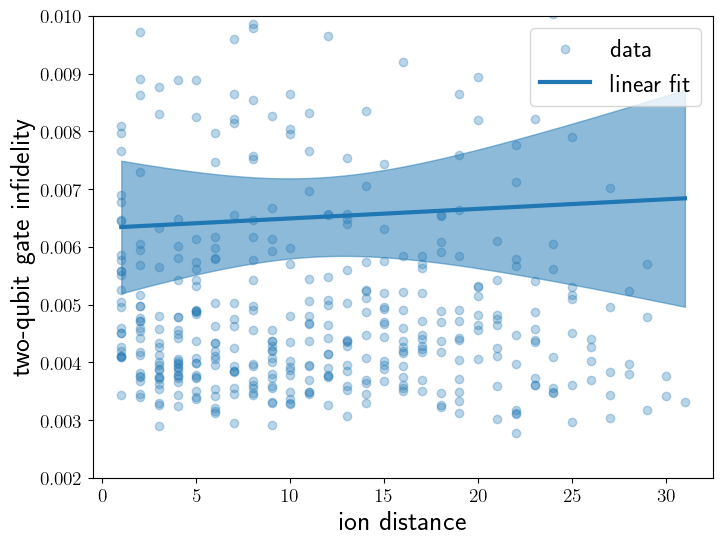

In [13]:
import statsmodels.api as sm

fig, ax = plt.subplots(1,1, figsize=(8,6))
x = dataDRBByPair['qubit distance'].values
y = dataDRBByPair['infidelity_pptt'].values * 1e-4

ax.scatter(x, y, alpha=0.3, color='#1f77b4', label='data')
#eb = dataDRBByPair['err_2q_ci'].values
#ax.errorbar(x, y, yerr=eb, alpha=0.3, marker='.', elinewidth=1, capsize=2, linewidth=0, color='#1f77b4', label='data')

# calculate best-fit line and interval
n_pts = 100
x_fit = sm.add_constant(x)
fit_results = sm.OLS(y, x_fit).fit()
eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
pred = fit_results.get_prediction(eval_x)

# draw the fit line and error interval
n_std = 2
ax.fill_between(
    eval_x[:, 1],
    (pred.predicted_mean - n_std * pred.se_mean),
    (pred.predicted_mean + n_std * pred.se_mean),
    alpha=0.5,
    color='#1f77b4',
)
ax.plot(eval_x[:, 1], pred.predicted_mean, color='#1f77b4', lw=3, label='linear fit')

ax.legend(prop={'size': 18})
ax.set_xlabel('ion distance', fontsize=20);
ax.set_ylabel(r'two-qubit gate infidelity', fontsize=20);
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(20 * 1e-4,100 * 1e-4);
#ax.set_ylim(10 * 1e-4,200 * 1e-4);
plt.savefig('fig_infidelity_qubitDistance_correlation.pdf', dpi=1000)


## 1Q DRB plots

In [14]:
data1QDRB = pd.read_json('../results/data_DRB1Q.json')

In [15]:
grouped1QDRB = data1QDRB.groupby(['beampath', 'ion_num'])[['infidelity_pptt']].mean().reset_index().copy()

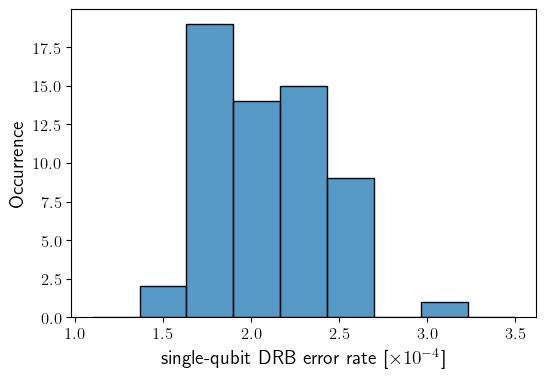

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
bins = np.linspace(1.1,3.5, 10)
ax = sns.histplot(data=grouped1QDRB, x='infidelity_pptt', bins=bins, color=colors[0], ax=ax)
ax.set_ylabel('Occurrence', fontsize=14);
ax.set_xlabel(r'single-qubit DRB error rate [$\times 10^{-4}$]', fontsize=14);  # \textpertenthousand
ax.tick_params(axis='both', labelsize=12)
#fig = plt.gcf()
#fig.set_size_inches(8,6)
plt.savefig('DRB_1Q_hist.pdf'); # format="pdf", bbox_inches = 'tight'

In [17]:
grouped_median = grouped1QDRB['infidelity_pptt'].median()

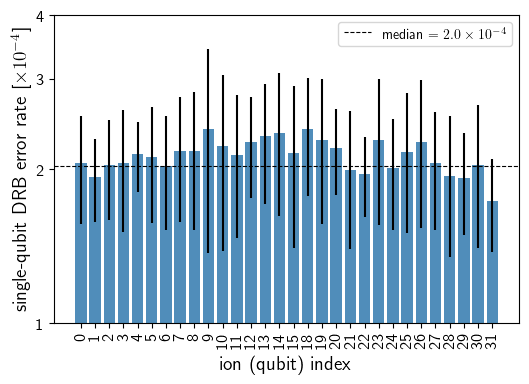

In [18]:
plt.figure(figsize=(6,4))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ions_indices = sorted(data1QDRB['ion_num'].unique())
bardata = [ data1QDRB[data1QDRB['ion_num'] == i]['infidelity_pptt'].to_numpy() for i in ions_indices]
plt.bar(np.arange(len(ions_indices)), [y.mean() for y in bardata], yerr=[y.std() for y in bardata],        
        color=(80/256,142/256,187/256))
plt.yscale('log')
plt.xticks(np.arange(len(ions_indices)), list(map(str, ions_indices)), rotation=90, fontsize=12)
plt.yticks([1,2,3,4], map(str,[1,2,3,4]), fontsize=12)

plt.xlabel("ion (qubit) index", fontsize=14)
plt.ylabel("single-qubit DRB error rate [$\\times 10^{-4}$]", fontsize=14)
plt.axhline(grouped_median, ls='--', color='k', lw=0.8, label=f'median = ${grouped_median:.1f} \\times 10^{{-4}}$')  # \\textpertenthousand
plt.legend()
plt.savefig("fig_1qdrb_by_qubits.pdf", format="pdf", bbox_inches = 'tight')